In [1]:
# Model design
import agentpy as ap
import networkx as nx
import numpy as np
import random 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

In [2]:
categories = ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'] # tech adoption categories
probabilities = [0.05, 0.1, 0.35, 0.35, 0.15] # fraction of the population that falls into each category
thresholds = [0.0, 0.1, 0.25, 0.5, 0.9] # threshold above which fraction of adopted neighbors will cause agent to adopt

rng = np.random.default_rng()

samples = rng.choice(categories, p=probabilities)
samples

def tech_categorical(categories,probabilities,population_size=100, rng=np.random.default_rng()):
    rng = np.random.default_rng()

    samples = rng.choice(categories, size=population_size,p=probabilities)
    return samples

In [4]:
class InnovationAgent(ap.Agent):
    def setup(self):
        self.adopted = False

        # rng = self.model.random
        rng = np.random
        self.category_idx = rng.choice(len(self.p.categories), p=self.p.probabilities)
        self.category = self.p.categories[self.category_idx]

    def num_adopted_neighbors(self):
        neighbors = self.network.neighbors(self)
        adopted = [n.adopted for n in neighbors]
        len_neighbors = len(adopted)
        num_adopters = sum(adopted)
        return num_adopters
        
    def neighbor_adopted_frac(self):
        neighbors = self.network.neighbors(self)
        adopted = [n.adopted for n in neighbors]
        len_neighbors = len(adopted)
        num_adopters = sum(adopted)

        return num_adopters/len_neighbors
        
    def adopt_innovation(self):
        if not self.adopted:
            if self.category == 'innovator':
                self.adopted = True
            elif self.category in ['early_adopter', 'early_majority', 'late_majority']:
                adopted_frac = self.neighbor_adopted_frac()
                
                threshold = self.p.thresholds[self.category_idx]
                if adopted_frac >= threshold:
                    self.adopted = True


In [5]:
class InnovationModel(ap.Model):

    def setup(self):
        graph = nx.watts_strogatz_graph(
            self.p.population,
            self.p.number_of_connections,
            self.p.network_rewire_probability,
        )

        # Create agents and a network
        self.agents = ap.AgentList(self, self.p.population, InnovationAgent)
        self.network = self.agents.network = ap.Network(self, graph)
        self.network.add_agents(self.agents, self.network.nodes)

    def update(self):
        frac_adopted = sum(1 for a in self.agents if a.adopted)/self.p.population
        self.record("fraction adopted" , frac_adopted)

        # Stop if everyone has adopted the tech
        if frac_adopted == 1:
            self.stop()

    def step(self):
        for agent in self.agents:
            agent.adopt_innovation() # Agents adopt innovations based on their category and network connections
    
    def end(self):
        pass
    



In [6]:
parameters = {
    'population': 100,
    "categories": ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'],
    "probabilities": [0.05, 0.1, 0.35, 0.35, 0.15],
    "thresholds": [0.0, 0.1, 0.25, 0.5, 0.9],
    "number_of_connections": 4,
    "network_rewire_probability": 0.1,
    "steps":100,
}

model = InnovationModel(parameters)
results = model.run()

Completed: 100 steps
Run time: 0:00:00.038035
Simulation finished


In [11]:
data = results.variables.InnovationModel
ax = data.plot()
plt.close()

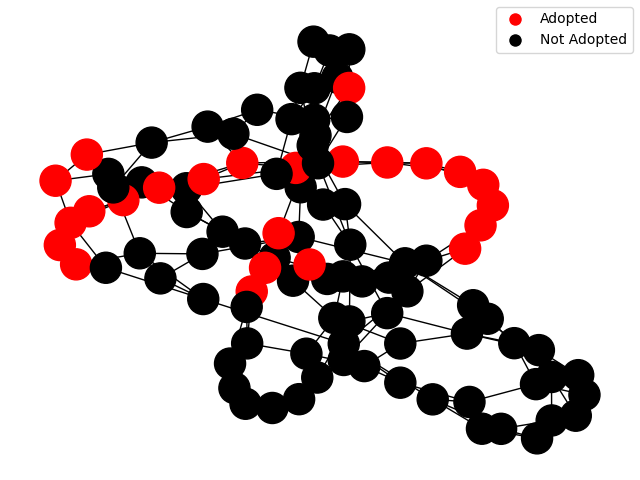

In [31]:
%matplotlib widget
# Get the network and agent data
network = model.network
adopted_states = [agent.adopted for agent in model.agents]

# Define node colors based on the adopted parameter
# For example, red for True, blue for False
node_colors = ['red' if adopted else 'black' for adopted in adopted_states]
labels = [str(agent.category_idx) for agent in model.agents]
labels = {i: labels[i] for i in range(len(labels))}
# labels = {node: str(agent.category_idx) for node, agent in network.nodes.agents.items()}

# Plot the network using networkx
pos = nx.spring_layout(network.graph)  # Define layout
nx.draw(
    network.graph,
    pos,
    node_color=node_colors,
    # labels=labels,
    with_labels=False,
    node_size=500,
    # font_color='white'
)

# Add a legend
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Adopted', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Not Adopted', markerfacecolor='black', markersize=10)
])
plt.title("Agent Network with Node Colors Based on Adoption Status")
plt.show()
# plt.close()


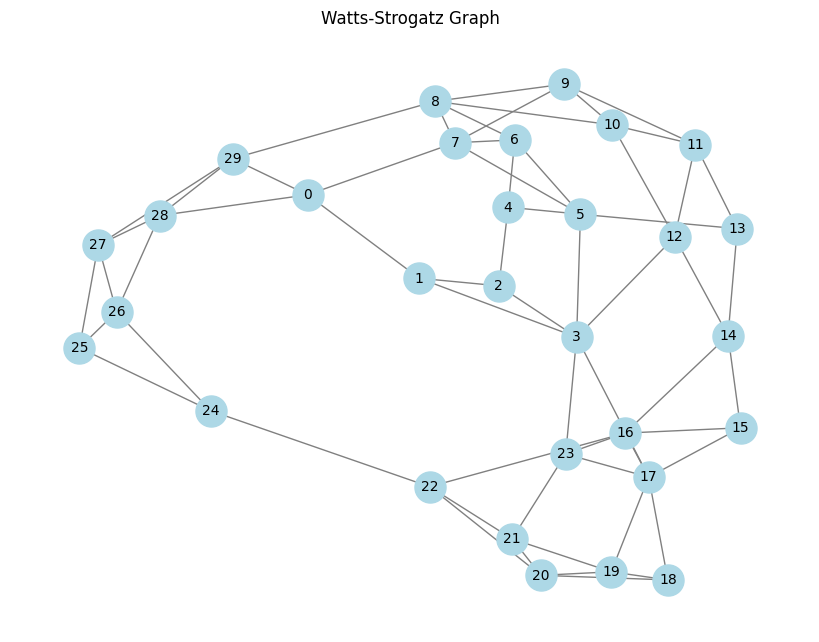

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

# Parameters for the Watts-Strogatz graph
n = 30  # Number of nodes
k = 4   # Each node is connected to k nearest neighbors in ring topology
p = 0.1 # Probability of rewiring each edge

# Create a Watts-Strogatz small-world graph
G = nx.watts_strogatz_graph(n, k, p)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)

# Show the plot
plt.title("Watts-Strogatz Graph")
plt.show()